# Exploratory analysis of Yelp dataset

In [2]:
#import all the necessary libraries
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

from collections import defaultdict

In [3]:
import nltk
import random
from nltk.classify.scikitlearn import SklearnClassifier
import pickle
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from nltk.classify import ClassifierI
from statistics import mode
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.feature_extraction.text import CountVectorizer

In [3]:
#import all the files
parent_dir = 'D:/DCU Documents/Semester 2/Data Analytics and Data Mining/Project/Kaggle Dataset/'

path_dic = {
            'B':parent_dir+'Business_SD_Mean.csv',
            'R':parent_dir+'Review_polarity_subjectivity.csv',
            'U':parent_dir+'User_SD_Mean.csv'
           }

user_data = pd.read_csv(path_dic['U'])
business_data = pd.read_csv(path_dic['B'])
review_data = pd.read_csv(path_dic['R'])

In [4]:
#check the size of each dataframe
print('U' + ' : ', user_data.shape)
print('B' + ' : ', business_data.shape)
print('R' + ' : ', review_data.shape)

U :  (73384, 18)
B :  (46367, 25)
R :  (134545, 12)


In [11]:
#Check the first value

user_data.head(1)
#del user_data['Unnamed: 0']

,user_id,user_name,yelping_since,elite,friends,fans,average_stars,user_review_count,user_cool_mean,user_funny_mean,user_useful_mean,user_star_mean,user_star_std,user_polarity_mean,user_polarity_std,user_subjectivity_mean,user_subjectivity_std
0,HM3JCyTu9PZOAvnbJV8Xsw,Kristen,2011-06-07 16:17:51,2016,"l-OwsyvDCOyUPYSiJvmQkQ, jk90O0GXI-G5P-UnygbOMg...",10,3.94,3,0.0,0.0,0.333333,5.0,0.0,0.315361,0.07431,0.580611,0.163659


In [12]:
#Check the first value

business_data.head(1)
#del business_data['Unnamed: 0']

,business_id,buz_name,address,city,state,postal_code,latitude,longitude,buz_stars,buz_review_count_x,...,buz_review_count_y,buz_cool_mean,buz_funny_mean,buz_useful_mean,buz_star_mean,buz_star_std,buz_polarity_mean,buz_polarity_std,buz_subjectivity_mean,buz_subjectivity_std
0,6iYb2HFDywm3zjuRg0shjw,Oskar Blues Taproom,921 Pearl St,Boulder,CO,80302,40.017544,-105.283348,4.0,86,...,5,0.2,0.2,0.4,4.2,1.788854,0.466493,0.230207,0.670037,0.054056


In [14]:
#Check the first value

review_data.head(1)
#del review_data['Unnamed: 0']

,review_id,user_id,business_id,review_stars,review_useful,review_funny,review_cool,text_stem,date,polarity,subjectivity
0,viFyq_J7aNNpTdpJZz0AZw,VVKciz1V7sK8J6Hg_Qs01A,5QzSq5x1pef5Jr5QWJ8sdw,1.0,0,0,0,They can't manage to get online orders right a...,2020-11-04 13:39:39,0.392857,0.580357


In [15]:
# holistic summary of the given data set. 
# "remove_bad_rowCol" can be turned on to remove non-informative col / row

def holistic_summary(df, remove_bad_rowCol = False, verbose = True):
    # remove non-informative columns
    if(remove_bad_rowCol):
        df = df.drop(df.columns[df.isnull().sum() >= .9 * len(df)], axis = 1)
        df = df.drop(df.index[df.isnull().sum(axis = 1) >= .5* len(df.columns)], axis = 0)
        
    # fix column names:
    df.columns = [c.replace(" ", "_").lower() for c in df.columns]
    
    print('***************************************************************')
    print('Begin holistic summary: ')
    print('***************************************************************\n')
    
    print('Dimension of df: ' + str(df.shape))
    print('Percentage of good observations: ' + str(1 - df.isnull().any(axis = 1).sum()/len(df)))
    print('---------------------------------------------------------------\n')
    
    print("Rows with nan values: " + str(df.isnull().any(axis = 1).sum()))
    print("Cols with nan values: " + str(df.isnull().any(axis = 0).sum()))
    print('Breakdown:')
    print(df.isnull().sum()[df.isnull().sum()!=0])
    print('---------------------------------------------------------------\n')
    
    print('Columns details: ')
    print('Columns with known dtypes: ')
    good_cols = pd.DataFrame(df.dtypes[df.dtypes!='object'], columns = ['type'])
    good_cols['nan_num'] = [df[col].isnull().sum() for col in good_cols.index]
    good_cols['unique_val'] = [df[col].nunique() for col in good_cols.index]
    good_cols['example'] = [df[col][1] for col in good_cols.index]
    good_cols = good_cols.reindex(good_cols['type'].astype(str).str.len().sort_values().index)
    print(good_cols)
    print('\n')
    
    try:
        print('Columns with unknown dtypes:')
        bad_cols = pd.DataFrame(df.dtypes[df.dtypes=='object'], columns = ['type'])
        bad_cols['nan_num'] = [df[col].isnull().sum() for col in bad_cols.index]
        bad_cols['unique_val'] = [df[col].nunique() for col in bad_cols.index]
        bad_cols['example(sliced)'] = [str(df[col][1])[:10] for col in bad_cols.index]
        bad_cols = bad_cols.reindex(bad_cols['example(sliced)'].str.len().sort_values().index)
        print(bad_cols)
    except Exception as e:
        print('No columns with unknown dtypes!')
    print('_______________________________________________________________\n\n\n')
    return df

In [16]:
#Check the summary of review_data dataframe
review_data.index = range(len(review_data))
review_data = holistic_summary(review_data)

***************************************************************
Begin holistic summary: 
***************************************************************

Dimension of df: (134545, 11)
Percentage of good observations: 1.0
---------------------------------------------------------------

Rows with nan values: 0
Cols with nan values: 0
Breakdown:
Series([], dtype: int64)
---------------------------------------------------------------

Columns details: 
Columns with known dtypes: 
                  type  nan_num  unique_val   example
review_useful    int64        0          86  0.000000
review_funny     int64        0          52  0.000000
review_cool      int64        0          82  0.000000
review_stars   float64        0           5  2.000000
polarity       float64        0       64688 -0.138333
subjectivity   float64        0       50616  0.580000


Columns with unknown dtypes:
               type  nan_num  unique_val example(sliced)
review_id    object        0      134545      _gcEQjB

In [11]:
# fixing dtypes: time and numeric variables
def fix_dtypes(df, time_cols = [], num_cols = []):
    
    print('***************************************************************')
    print('Begin fixing data types: ')
    print('***************************************************************\n')
    
    def fix_time_col(df, time_cols):
        for time_col in time_cols:
            df[time_col] = pd.to_datetime(df[time_col], errors = 'coerce')
        print('---------------------------------------------------------------')
        print('The following time columns has been fixed: ')
        print(time_cols)
        print('---------------------------------------------------------------\n')

    def fix_factor_col(df):
        categorical_col = []
        for col in df.columns:
            if (df[col].nunique()<12) & (df[col].nunique()<len(df)/10):
                df[col] = df[col].astype('category')
                categorical_col.append(col)
        print('---------------------------------------------------------------')
        print('The following category columns has been fixed: ')
        print(categorical_col)
        print('---------------------------------------------------------------\n')

    def fix_num_col(df, num_cols):
        for col in num_cols:
            df[col] = pd.to_numeric(df[col], errors = 'coerce')
        print('---------------------------------------------------------------')
        print('The following number columns has been fixed: ')
        print(num_cols)
        print('---------------------------------------------------------------\n')
        
    if(len(num_cols) > 0):
        fix_num_col(df, num_cols)
    fix_time_col(df, time_cols)
    #fix_factor_col(df)
    #fix_string_col(df)
    print('---------------------------------------------------------------')
    print('Final data types:')
    result = pd.DataFrame(df.dtypes, columns = ['type'])
    result = result.reindex(result['type'].astype(str).str.len().sort_values().index)
    print(result)
    print('_______________________________________________________________\n\n\n')
    return df


In [5]:
# A function that adds number of ppl in each bucket
def annot():
    for p in ax.patches:
        x=p.get_bbox().get_points()[:,0]
        y=p.get_bbox().get_points()[1,1]
        ax.annotate('{:.0f}'.format(y), (x.mean(), y), 
                ha='center', va='bottom') # set the alignment of the text

No handles with labels found to put in legend.


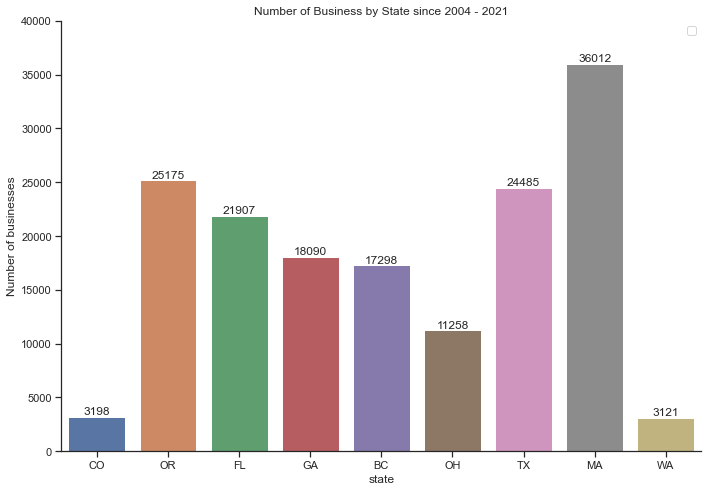

In [7]:
#bar chart of all the business in Yelp dataset since 2004 - 2021

full_business_data = pd.read_csv('D:/DCU Documents/Semester 2/Data Analytics and Data Mining/Project/Kaggle Dataset/business_s.csv')
sns.set(style = 'ticks')
ax = sns.countplot(x = 'state',data = full_business_data)
plt.rcParams["figure.figsize"] = (10,7)


# plt.xlabel('')
# plt.xticks(np.arange(0, 7), ['Mon', 'Tues', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun'])
plt.ylabel('Number of businesses')
plt.title('Number of Business by State since 2004 - 2021')
plt.ylim(0, 40000)
sns.despine()
annot()
plt.legend(loc = 0)
plt.tight_layout()
plt.savefig('D:/DCU Documents/Semester 2/Data Analytics and Data Mining/Project/Kaggle Dataset/State Distribution.png', dpi = 300)  
plt.show()

In [ ]:
#Read all the review dataset since 2020 and convert the dtype of dates column to dattime object
review_data2020_2021 = pd.read_csv('D:/DCU Documents/Semester 2/Data Analytics and Data Mining/Project/Kaggle Dataset/Review2020.csv')
review_data2020_2021 = fix_dtypes(review_data2020_2021, time_cols = ['date'])

In [34]:
# Adding week and weekday column
review_data2020_2021['year'] = [review_data2020_2021['date'][i].year for i in range(len(review_data2020_2021))]
review_data2020_2021['month'] = [review_data2020_2021['date'][i].month for i in range(len(review_data2020_2021))]
review_data2020_2021['week'] = [review_data2020_2021['date'][i].isocalendar()[1] for i in range(len(review_data2020_2021))]
review_data2020_2021['weekday'] = [review_data2020_2021['date'][i].weekday() for i in range(len(review_data2020_2021))]

In [36]:
#Create a column pos with every rating greater than 3 is regarded as pos(1) and neg(0)
review_data2020_2021['pos'] = np.where(review_data2020_2021['stars'] >3, 1, 0)

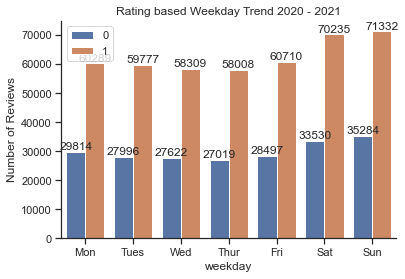

In [41]:
#bar chart with total count of reviews everyday since 2020

%matplotlib inline
sns.set(style = 'ticks')
ax = sns.countplot(x = 'weekday',hue = 'pos', data = review_data2020_2021)

# plt.xlabel('')
plt.xticks(np.arange(0, 7), ['Mon', 'Tues', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun'])
plt.ylabel('Number of Reviews')
plt.title('Rating based Weekday Trend 2020 - 2021')
sns.despine()
annot()
plt.legend(loc = 0)
plt.savefig('D:/DCU Documents/Semester 2/Data Analytics and Data Mining/Project/Kaggle Dataset/Weekday_Trend.png', dpi = 300)  
plt.show()

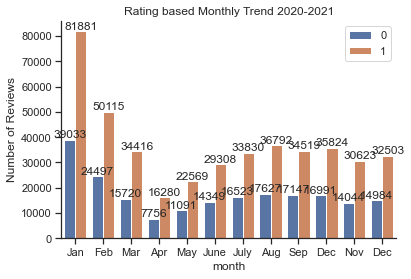

In [42]:
#bar chart with total count of reviews every month since 2020

sns.set(style = 'ticks')
ax = sns.countplot(x = 'month',hue = 'pos', data = review_data2020_2021)

# plt.xlabel('')
plt.xticks(np.arange(0, 12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July', 'Aug', 'Sep', 'Dec', 'Nov', 'Dec'])
plt.ylabel('Number of Reviews')
plt.title('Rating based Monthly Trend 2020-2021')
#plt.ylim(0, 4000)
sns.despine()
annot()
plt.legend(loc = 0)
plt.savefig('D:/DCU Documents/Semester 2/Data Analytics and Data Mining/Project/Kaggle Dataset/Monthly Trend.png', dpi = 300)  
plt.show()

In [9]:
#read all the reviews since 2015
review_data_years = pd.read_csv('D:/DCU Documents/Semester 2/Data Analytics and Data Mining/Project/Kaggle Dataset/R.csv'+'/0.part')

In [12]:
#convert the dtype of dates column to dattime object
review_data_years = fix_dtypes(review_data_years, time_cols = ['date'])

***************************************************************
Begin fixing data types: 
***************************************************************

---------------------------------------------------------------
The following time columns has been fixed: 
['date']
---------------------------------------------------------------

---------------------------------------------------------------
Final data types:
                       type
Unnamed: 0            int64
useful                int64
funny                 int64
cool                  int64
review_id            object
user_id              object
business_id          object
text                 object
stars               float64
date         datetime64[ns]
_______________________________________________________________





In [13]:
#Create a column year to conatin the year in which  the review was given
review_data_years['year'] = [review_data_years['date'][i].year for i in range(len(review_data_years))]

In [15]:
#Create a column pos with every rating greater than 3 is regarded as pos(1) and neg(0)
review_data_years['pos'] = np.where(review_data_years['stars'] >3, 1, 0)

In [17]:
#REmove the reviews which were given in 2014 since all the review are not present in the csv file
review_data_years = review_data_years[review_data_years['year'] > 2014]

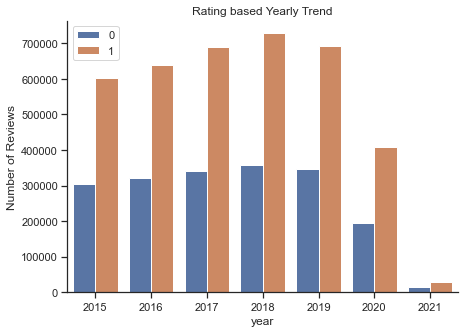

In [18]:
#bar chart with total count of reviews every month year since 2015
plt.rcParams["figure.figsize"] = (7,5)
ax = sns.countplot(x = 'year',hue = 'pos', data = review_data_years)
plt.ylabel('Number of Reviews')
plt.title('Rating based Yearly Trend')
sns.despine()
plt.legend(loc = 2)
plt.savefig('D:/DCU Documents/Semester 2/Data Analytics and Data Mining/Project/Kaggle Dataset/Yearly Trend.png', dpi = 300)  
plt.show()